In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import vnn
import torchvision
from imp import reload

In [3]:
reload(vnn)

def make_conv_net(mono):
    #torch.manual_seed(42)
    model = nn.Sequential(vnn.Conv2d(10, 30, 96, 5, stride=1, padding=4, mono=mono, first_layer=True),
                          vnn.tReLU(),
                          vnn.Conv2d(10, 96, 96, 5, stride=1, padding=4, mono=mono),
                          vnn.tReLU(),
                          vnn.Conv2d(10, 96, 96, 5, stride=1, padding=4, mono=mono),
                          vnn.tReLU(),
                          vnn.Conv2d(10, 96, 96, 5, stride=5, padding=4, mono=mono),
                          vnn.tReLU(),
                          vnn.Flatten(),
                          vnn.Linear(10, 9600, 1200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 1200, 600, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 600, 1, mono=mono)).to(0)
    return model

def make_conv_net(mono):
    #torch.manual_seed(42)
    model = nn.Sequential(vnn.Conv2d(10, 30, 64, 5, stride=1, padding=4, mono=mono, first_layer=True),
                          vnn.nReLU(),
                          vnn.AvgPool2d(2),
                          vnn.Conv2d(10, 64, 64, 5, stride=1, padding=4, mono=mono),
                          vnn.nReLU(),
                          vnn.AvgPool2d(2),
                          vnn.Conv2d(10, 64, 64, 5, stride=1, padding=4, mono=mono),
                          vnn.nReLU(),
                          vnn.AvgPool2d(2),
                          vnn.Flatten(),
                          vnn.Linear(10, 3136, 1200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 1200, 600, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 600, 1, mono=mono)).to(0)
    return model


def make_conv_input():
    #torch.manual_seed(42)
    data = torch.randn(40, 3, 32, 32)
    input = vnn.expand_input_conv(data, 10).to(0)
    return input

In [4]:
reload(vnn)

def make_fc_net(mono):
    #torch.manual_seed(42)
    model = nn.Sequential(vnn.Linear(10, 7840, 200, mono=mono, first_layer=True),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 1, mono=mono)).to(0)
    return model

def make_fc_input():
    #torch.manual_seed(42)
    data = torch.randn(1, 784)
    input = vnn.expand_input(data, 10).to(0)
    return input

In [5]:
conv_input = make_conv_input()
conv_mono = make_conv_net(mono=True)
conv_mono_out = conv_mono(conv_input).detach().cpu().numpy()
conv = make_conv_net(mono=False)
conv_out = conv(conv_input).detach().cpu().numpy()

fc_input = make_fc_input()
fc_mono = make_fc_net(mono=True)
fc_mono_out = fc_mono(fc_input).detach().cpu().numpy()
fc = make_fc_net(mono=False)
fc_out = fc(fc_input).detach().cpu().numpy()

torch.Size([40, 64, 36, 36])
torch.Size([40, 64, 22, 22])
torch.Size([40, 64, 15, 15])
Instantiated t with shape (10, 1200)
Instantiated t with shape (10, 600)
torch.Size([40, 64, 36, 36])
torch.Size([40, 64, 22, 22])
torch.Size([40, 64, 15, 15])
Instantiated t with shape (10, 1200)
Instantiated t with shape (10, 600)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)


In [6]:
opt = optim.SGD(conv_mono.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(reduction="mean")
X = torch.clone(conv_mono[:2](conv_input).detach())
#X[:, 0] = 1.
#X[:, 1:] = 0.
X.requires_grad = True
out = conv_mono[2:](X)[..., 0]
#err = F.softmax(out.detach().cpu(), dim=1) - torch.eye(10)[labels]
#loss = loss_fn(out, labels.to(0))

loss = out[0, 4]
opt.zero_grad()
loss.backward()

X_grad = X.grad.detach().cpu().numpy()
X_grad = X_grad[0, 4]
X_grad.shape

torch.Size([40, 64, 36, 36])
torch.Size([40, 64, 22, 22])
torch.Size([40, 64, 15, 15])


(64, 36, 36)

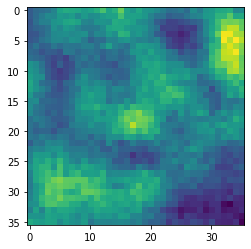

In [100]:
plt.imshow(X_grad[10])

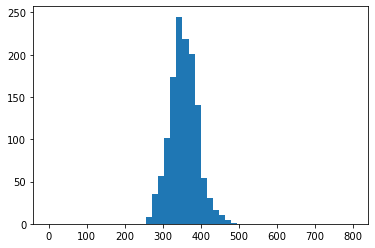

5.737169707329392

In [95]:
d = X_grad[30].flatten()
d = d[d > 1e-8]
plt.hist(d, bins=50, range=(0, 800))
plt.show()

np.rad2deg(np.arccos(1./np.sqrt(1. + (d.std()/d.mean())**2)))

Text(0.5, 0, 'output value')

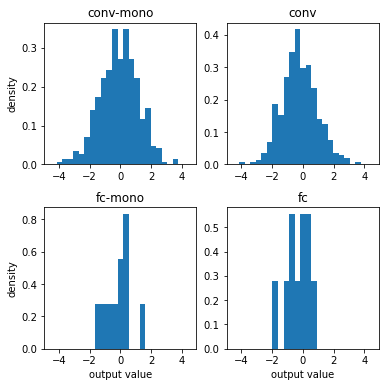

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)
ax1, ax2, ax3, ax4 = axes.flatten()

rng = (-4.5, 4.5)
ax1.hist(conv_mono_out.flatten(), bins=25, density=True, range=rng)
ax2.hist(conv_out.flatten(), bins=25, density=True, range=rng)
ax3.hist(fc_mono_out.flatten(), bins=25, density=True, range=rng)
ax4.hist(fc_out.flatten(), bins=25, density=True, range=rng)

ax1.set_title("conv-mono")
ax2.set_title("conv")
ax3.set_title("fc-mono")
ax4.set_title("fc")

ax1.set_ylabel("density")
ax3.set_ylabel("density")

ax3.set_xlabel("output value")
ax4.set_xlabel("output value")

#plt.savefig("figs/inits.pdf", bbox_inches="tight")

In [86]:
labels = torch.randint(0, 10, (1,))
def compare_grads(model, input, layer_idx):
    opt = optim.SGD(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss(reduction="mean")
    
    out = model(input)[..., 0]
    loss = loss_fn(out, labels.to(0))

    opt.zero_grad()
    loss.backward()
    G1 = model[layer_idx].weight.grad.detach().cpu().numpy().flatten()

    opt.zero_grad()
    vnn.set_model_grads(model, out.detach(), labels.to(0))
    G2 = model[layer_idx].weight.grad.detach().cpu().numpy().flatten()
    
    return G1, G2

In [90]:
conv_input = make_conv_input()
conv = make_conv_net(mono=False)
conv_mono = make_conv_net(mono=True)

all_G_mono = [compare_grads(conv_mono, conv_input, i) for i in (0, 3, 6, 10, 12, 14)]
all_G = [compare_grads(conv, conv_input, i) for i in (0, 3, 6, 10, 12, 14)]

Instantiated t with shape (10, 96, 36, 36)
Instantiated t with shape (10, 96, 22, 22)
Instantiated t with shape (10, 96, 15, 15)
Instantiated t with shape (10, 1200)
Instantiated t with shape (10, 600)
0 get mask
3 get mask
6 get mask
10 get mask
12 get mask
0 get mask
3 get mask
6 get mask
10 get mask
12 get mask
0 get mask
3 get mask
6 get mask
10 get mask
12 get mask
0 get mask
3 get mask
6 get mask
10 get mask
12 get mask
0 get mask
3 get mask
6 get mask
10 get mask
12 get mask
0 get mask
3 get mask
6 get mask
10 get mask
12 get mask
Instantiated t with shape (10, 96, 36, 36)
Instantiated t with shape (10, 96, 22, 22)
Instantiated t with shape (10, 96, 15, 15)
Instantiated t with shape (10, 1200)
Instantiated t with shape (10, 600)
0 get mask
3 get mask
6 get mask
10 get mask
12 get mask
0 get mask
3 get mask
6 get mask
10 get mask
12 get mask
0 get mask
3 get mask
6 get mask
10 get mask
12 get mask
0 get mask
3 get mask
6 get mask
10 get mask
12 get mask
0 get mask
3 get mask
6 ge

In [91]:
from scipy.stats import pearsonr
def plot_conv_grad(all_G):
    fig, axes = plt.subplots(1, 6, figsize=(15, 2), dpi=120)
    fig.subplots_adjust(wspace=0.3)
    layers = np.arange(6) + 1
    for i in range(6):
        G1, G2 = all_G[i]
        axes[i].scatter(G1[:], G2[:], lw=0, s=1)
        axes[i].set_xlabel("gradient")
        axes[i].set_title("layer {} ({})".format(layers[i], ("conv" if i <= 2 else "fc")))
        print(np.rad2deg(np.arccos(pearsonr(G1, G2)[0])))
    axes[0].set_ylabel("global err. rule")

89.89505620270293
89.55484858739064
89.29534689126388
86.07422011123325
92.52102106620468
3.4150945850063763e-06


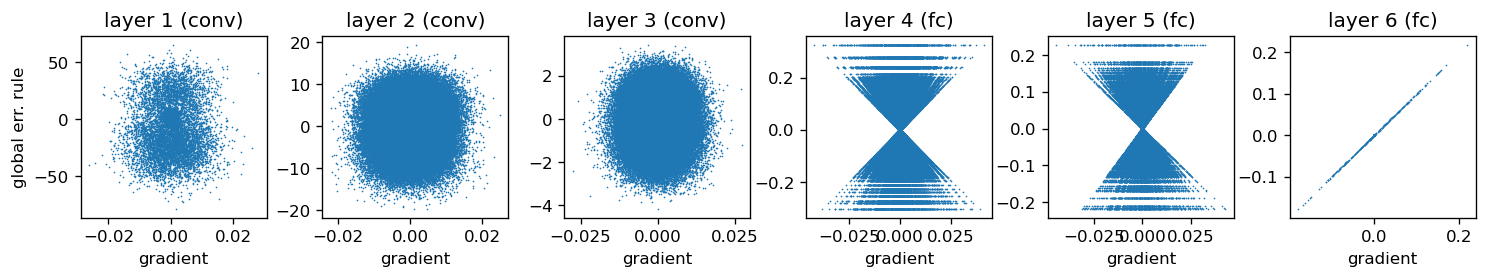

2.2824802642031625
2.5097966689141864
4.946811678997014
8.722787439811885
56.54424952158305
3.4150945850063763e-06


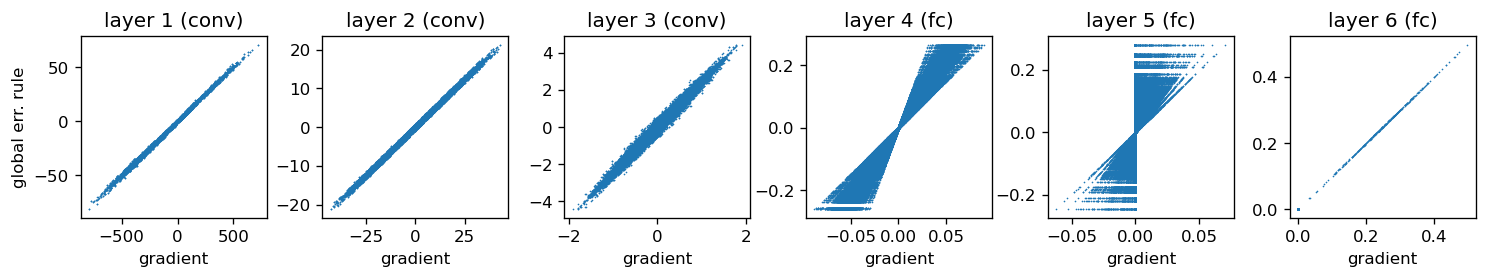

In [92]:
plot_conv_grad(all_G)
#plt.savefig("figs/grads_conv_mixed.png", bbox_inches="tight", dpi=300, facecolor="white")
plt.show()

plot_conv_grad(all_G_mono)
#plt.savefig("figs/grads_conv_mono.png", bbox_inches="tight", dpi=300, facecolor="white")
plt.show()

In [120]:
fc_input = make_fc_input()
fc = make_fc_net(mono=False)
fc_mono = make_fc_net(mono=True)

all_G_mono = [compare_grads(fc_mono, fc_input, i) for i in (0, 2, 4, 6, 8, 10)]
all_G = [compare_grads(fc, fc_input, i) for i in (0, 2, 4, 6, 8, 10)]

Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 get mask
8 get mask
0 get mask
2 get mask
4 get mask
6 

In [121]:
def plot_fc_grad(all_G):
    fig, axes = plt.subplots(1, 6, figsize=(15, 2), dpi=120)
    fig.subplots_adjust(wspace=0.3)
    layers = np.arange(6) + 1
    for i in range(6):
        G1, G2 = all_G[i]
        axes[i].scatter(G1, G2, lw=0, s=1)
        axes[i].set_xlabel("gradient")
        axes[i].set_title("layer {} (fc)".format(layers[i]))
    axes[0].set_ylabel("global err. rule")

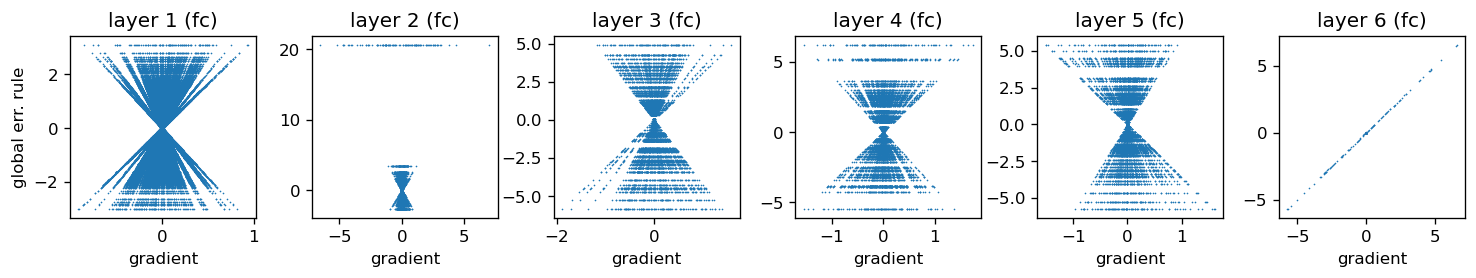

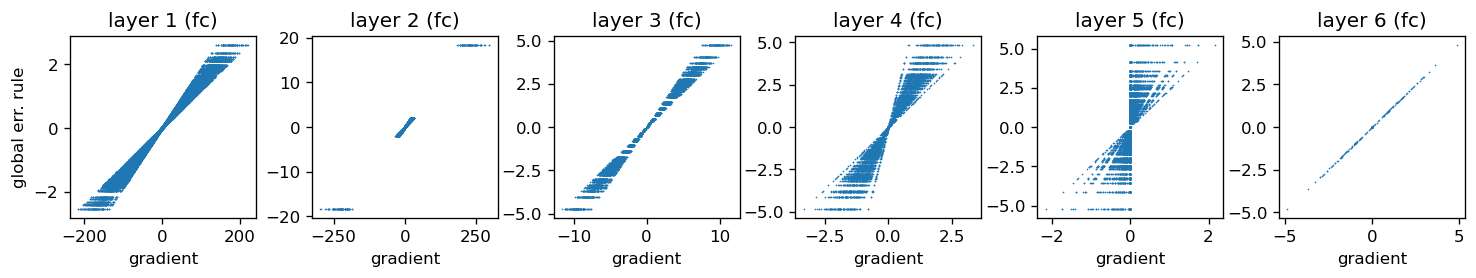

In [122]:
plot_fc_grad(all_G)
#plt.savefig("figs/grads_fc_mixed.png", bbox_inches="tight", dpi=300, facecolor="white")
plt.show()

plot_fc_grad(all_G_mono)
#plt.savefig("figs/grads_fc_mono.png", bbox_inches="tight", dpi=300, facecolor="white")
plt.show()

In [137]:
conv = vnn.Conv2d(10, 3, 5, 4, stride=1, mono=False)
W = torch.randn(5, 3, 4, 4)
b = torch.randn(10, 5)
with torch.no_grad():
    conv.conv.weight[:] = W
    conv.bias[:] = b

In [138]:
data = torch.randn(128, 10, 3, 32, 32)
out = conv(data)

In [139]:
out_2 = torch.zeros_like(out)
for i in range(10):
    out_2[:, i] = F.conv2d(data[:, i], weight=W, bias=b[i])

In [140]:
torch.max(torch.abs(out - out_2))

tensor(0., grad_fn=<MaxBackward1>)

In [84]:
W = torch.randn(1, 100)
W[::2].shape

torch.Size([1, 100])

In [126]:

def convolutional_outer_product(x1, x2, kernel_size, stride=1, padding=0):
    #assumes stride, padding, dilation are all defaults!
    #x1 = (batch_size, in_channels, h_in, w_in)
    #x2 = (batch_size, out_channels, h_out, w_out)
    #out = (batch_size, out_chanels, in_channels, kernel_size, kernel_size)
    batch_size = x1.shape[0]
    if x2.shape[0] != batch_size:
        raise ValueError("x1 and x2 must have the same batch size")
    in_channels = x1.shape[1]
    out_channels = x2.shape[1]
    h_in, w_in = x1.shape[2:]
    h_out, w_out = x2.shape[2:]

    x1_prime = x1.permute(1, 0, 2, 3)
    x2_prime = x2.view(batch_size*out_channels, h_out, w_out).unsqueeze(1)
    #print(x1_prime.shape, x2_prime.shape)

    out_prime = F.conv2d(input=x1_prime, weight=x2_prime, groups=batch_size, dilation=stride, stride=1, padding=padding)
    print(out_prime.shape)
    
    out_prime = out_prime[:, :, :kernel_size, :kernel_size]

    out = out_prime.view(in_channels, batch_size, out_channels, kernel_size, kernel_size).permute(1, 2, 0, 3, 4)
    return out


x1 = torch.randn(128, 5, 28, 28)
W = torch.randn(3, 5, 4, 4)
x2 = F.conv2d(x1, weight=W, stride=2, padding=3)
#x1.shape, x2.shape
batch_size = 128
h_out, w_out = x2.shape[2:]
out_channels = 3
stride = 2
padding = 3

In [129]:
out1 = convolutional_outer_product(x1, x2, kernel_size=4, stride=2, padding=padding)
out2 = convolutional_outer_product(x1, x2, kernel_size=4, stride=2, padding=padding+1)


torch.Size([5, 384, 4, 4])
torch.Size([5, 384, 6, 6])


(array([  21.,  243., 1382., 4880., 9551., 8799., 4292., 1328.,  211.,
          13.]),
 array([-1209.8767  ,  -963.385   ,  -716.8933  ,  -470.4016  ,
         -223.90991 ,    22.581787,   269.0735  ,   515.5652  ,
          762.0569  ,  1008.5486  ,  1255.0403  ], dtype=float32),
 <BarContainer object of 10 artists>)

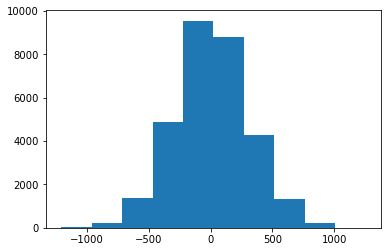

In [125]:
plt.hist((out1-out2).numpy().flatten())

In [70]:
from scipy.optimize import linprog

def in_hull(points, x):
    n_points = len(points)
    n_dim = len(x)
    c = np.zeros(n_points)
    A = np.r_[points.T,np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b)
    return lp.success

def est_prob(n_points, n_dim):
    results = np.zeros(1000)
    for i in range(len(results)):
        Z = np.random.randn(n_points, n_dim)
        Z = Z / np.linalg.norm(Z, axis=1, keepdims=True)
        x = np.zeros(n_dim)
        if in_hull(Z, x):
            results[i] = 1.
    p = np.mean(results)
    return p

est_prob(10, 5)

0.496

In [22]:
x

array([1.e-06, 1.e-06])